## Notes


For every CWM, here we compute the position wide sum of CWM contrib scores for the
30 bp and trimmed motifs, to be used as a motif importance metric in downstream analyses.

_Run on durga_

# Setup

In [15]:
%load_ext autoreload
%autoreload 2

# deal with matplotlib plots
%matplotlib inline

# display all outputs in a cell
get_ipython().ast_node_interactivity = 'all'

from IPython.display import display, HTML

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# misc
import sys
import os
import numpy as np
import random
from tqdm import tqdm
import pandas as pd

# io
import h5py

# plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn; seaborn.set_style('white')
import matplotlib.ticker as ticker
import plotnine as pn
import logomaker
import tangermeme
from tangermeme.plot import plot_logo
from tangermeme.utils import reverse_complement
import matplotlib.animation as animation

sys.path.append("..")
from tangermeme_utils.utils import plot_motif
from chrombpnet_utils.modisco import trim_cwm

# editable text in PDFs
# https://stackoverflow.com/a/54111532
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Variables

In [8]:
INPUTLEN = 2114
OUTPUTLEN = 1000
SHIFT_REL_INPUT = np.int64((2114 - 1000) / 2)
SHIFT_REL_INPUT

NARROWPEAK_SCHEMA = ["chr", "start", "end", "1", "2", "3", "4", "5", "6", "summit"]

LOGO_ALPHABET = 'ACGT'

# finemo colorscheme
LOGO_COLORS = {"A": '#109648', "C": '#255C99', "G": '#F7B32B', "T": '#D62839'}

# logomaker colorscheme
LOGO_COLORS2= {
        'G': [1, .65, 0],
        'T': [1, 0, 0],
        'C': [0, 0, 1],
        'A': [0, .5, 0]
    }

CHAR_IGNORE = ['QWERYUIOPSDFHJKLZXVBNM']

np.int64(557)

# Paths

In [9]:
with open("../../DURGA_DIRS.txt", 'r') as f:
	proj_in = f.readline().strip()
	proj_out = f.readline().strip()

with open("../../AK_PROJ_DIR.txt", 'r') as f:
    kundaje_dir = f.readline().strip()

# Get modisco objects

In [10]:
cluster_meta = pd.read_csv(os.path.join(proj_out, "03-chrombpnet/01-models/qc/chrombpnet_models_keep2.tsv"), sep="\t", header=None)

# set column names
cluster_meta.columns = ["cluster", "folds", "cluster_ID"]

cluster_meta.head()

cluster_meta.shape

,cluster,folds,cluster_ID
0,Adrenal_c0,"fold_0,fold_1,fold_2,fold_3,fold_4",AG_0
1,Adrenal_c1,"fold_0,fold_1,fold_2,fold_3,fold_4",AG_1
2,Adrenal_c2,"fold_0,fold_1,fold_2,fold_3,fold_4",AG_2
3,Adrenal_c3,"fold_0,fold_1,fold_2,fold_3,fold_4",AG_3
4,Brain_c0,"fold_0,fold_1,fold_2,fold_3,fold_4",BR_0


(189, 3)

# Inspect summed contrib scores for some examples

In [33]:
cluster = "Heart_c0"
path_modisco = proj_out + f"03-chrombpnet/01-models/modisco/bias_Heart_c0_thresh0.4/{cluster}/counts_modisco_output.h5"
modisco = h5py.File(path_modisco, 'r')
modisco.keys()

<KeysViewHDF5 ['neg_patterns', 'pos_patterns']>

(14, 4)

np.float64(0.6811012164804402)

np.float64(0.04865008689146001)

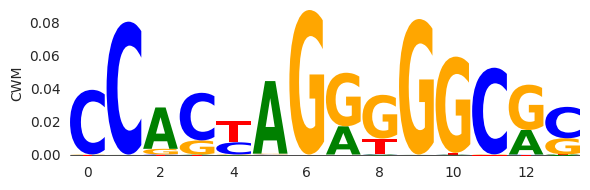

In [34]:
cwm = modisco['pos_patterns']['pattern_0']['contrib_scores'][()]
trimmed_cwm, _, _ = trim_cwm(cwm)
trimmed_cwm.shape
plot_motif(trimmed_cwm.T)
trimmed_cwm.sum()
trimmed_cwm.sum()/trimmed_cwm.shape[0]

(14, 4)

np.float64(0.33926301833399025)

np.float64(0.02423307273814216)

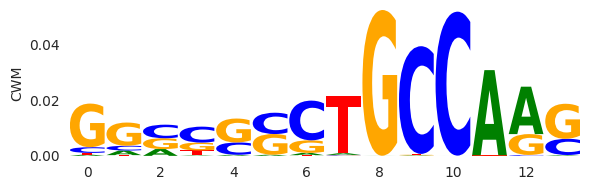

In [35]:
cwm = modisco['pos_patterns']['pattern_10']['contrib_scores'][()]
trimmed_cwm, _, _ = trim_cwm(cwm)
trimmed_cwm.shape
plot_motif(trimmed_cwm.T)
trimmed_cwm.sum()
trimmed_cwm.sum()/trimmed_cwm.shape[0]

(13, 4)

np.float64(-0.275456271520475)

np.float64(-0.021188943963113462)

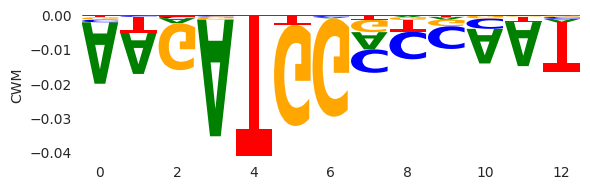

In [36]:
cwm = modisco['neg_patterns']['pattern_0']['contrib_scores'][()]
trimmed_cwm, _, _ = trim_cwm(cwm)
trimmed_cwm.shape
plot_motif(trimmed_cwm.T)
trimmed_cwm.sum()
trimmed_cwm.sum()/trimmed_cwm.shape[0]

# Compute across motifs and cell types

In [21]:
# collect a dict of dfs
cwm_means = []

for cluster in cluster_meta['cluster'].values:
	
	print(cluster)
	path_modisco = proj_out + f"03-chrombpnet/01-models/modisco/bias_Heart_c0_thresh0.4/{cluster}/counts_modisco_output.h5"
	modisco = h5py.File(path_modisco, 'r')

	# collect a dict of dfs
	for grp in modisco.keys():

		for motif in modisco[grp].keys():

			# calculate sum of contribs and mean of contribs, across trimmed CWMs
			cwm = modisco[grp][motif]['contrib_scores'][()]
			trimmed_cwm, _, _ = trim_cwm(modisco[grp][motif]['contrib_scores'][()])
			cwm_sum = trimmed_cwm.sum()
			cwm_mean = cwm_sum/trimmed_cwm.shape[0]
			abs_cwm_sum = np.abs(trimmed_cwm).sum()
			abs_cwm_mean = abs_cwm_sum/trimmed_cwm.shape[0]

			cwm_means.append([cluster, grp, motif, cwm_sum, abs_cwm_sum, cwm_mean, abs_cwm_mean])

Adrenal_c0
Adrenal_c1
Adrenal_c2
Adrenal_c3
Brain_c0
Brain_c1
Brain_c10
Brain_c11
Brain_c12
Brain_c13
Brain_c14
Brain_c15
Brain_c16
Brain_c17
Brain_c2
Brain_c3
Brain_c4
Brain_c5
Brain_c6
Brain_c7
Brain_c8
Brain_c9
Eye_c0
Eye_c1
Eye_c10
Eye_c11
Eye_c12
Eye_c13
Eye_c14
Eye_c15
Eye_c16
Eye_c17
Eye_c18
Eye_c2
Eye_c3
Eye_c4
Eye_c5
Eye_c6
Eye_c7
Eye_c8
Eye_c9
Heart_c0
Heart_c1
Heart_c10
Heart_c11
Heart_c12
Heart_c13
Heart_c14
Heart_c15
Heart_c2
Heart_c3
Heart_c4
Heart_c5
Heart_c6
Heart_c7
Heart_c8
Heart_c9
Liver_c0
Liver_c1
Liver_c10
Liver_c11
Liver_c12
Liver_c13
Liver_c2
Liver_c3
Liver_c4
Liver_c5
Liver_c6
Liver_c7
Liver_c8
Liver_c9
Lung_c0
Lung_c1
Lung_c10
Lung_c11
Lung_c12
Lung_c13
Lung_c14
Lung_c15
Lung_c16
Lung_c17
Lung_c2
Lung_c3
Lung_c4
Lung_c5
Lung_c6
Lung_c7
Lung_c8
Lung_c9
Muscle_c0
Muscle_c1
Muscle_c10
Muscle_c11
Muscle_c12
Muscle_c13
Muscle_c14
Muscle_c15
Muscle_c16
Muscle_c17
Muscle_c18
Muscle_c19
Muscle_c2
Muscle_c20
Muscle_c21
Muscle_c3
Muscle_c4
Muscle_c5
Muscle_c6
Muscle_c7


In [22]:
# convert list to df
cwm_means_df = pd.DataFrame(cwm_means, columns=["cluster", "pattern_class", "motif", "cwm_sum", "abs_cwm_sum", "cwm_mean", "abs_cwm_mean"])

# concatenate two columns
cwm_means_df['component_pattern'] = cwm_means_df['cluster'] + "__" + cwm_means_df['pattern_class'] + "." + cwm_means_df['motif']

cwm_means_df.head()

,cluster,pattern_class,motif,cwm_sum,abs_cwm_sum,cwm_mean,abs_cwm_mean,component_pattern
0,Adrenal_c0,pos_patterns,pattern_0,0.362828,0.366623,0.051833,0.052375,Adrenal_c0__pos_patterns.pattern_0
1,Adrenal_c0,pos_patterns,pattern_1,0.426939,0.429196,0.060991,0.061314,Adrenal_c0__pos_patterns.pattern_1
2,Adrenal_c0,pos_patterns,pattern_10,0.259504,0.260040,0.032438,0.032505,Adrenal_c0__pos_patterns.pattern_10
3,Adrenal_c0,pos_patterns,pattern_11,0.424052,0.440610,0.017669,0.018359,Adrenal_c0__pos_patterns.pattern_11
4,Adrenal_c0,pos_patterns,pattern_12,0.244701,0.245307,0.030588,0.030663,Adrenal_c0__pos_patterns.pattern_12


In [23]:
# write out
cwm_means_df.to_csv(os.path.join(proj_out, "03-chrombpnet/02-compendium/modisco_compiled/cwm_sums_df.tsv"), sep="\t", index=False)